# Start

In [4]:
from google.colab import drive #mount Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
import os
import sys
import logging
import time
import h5py
import math

import json
import scipy.io.wavfile as wavf
from sklearn.preprocessing import minmax_scale
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from PIL import ImageOps
from keras.preprocessing.image import img_to_array,array_to_img

In [6]:
# set root dir: the path to the github repo folder "XAI_spec_TSC" in your google drive
root_dir = '/gdrive/My Drive/XAI_spec_AudioMNIST/'

paths = {
    'root': root_dir,
    'dataset': os.path.join(root_dir,'AudioMNIST-master'),
    'data': os.path.join(root_dir,'AudioMNIST-master/data'),
    'meta': os.path.join(root_dir,'AudioMNIST-master/data/audioMNIST_meta.txt'),
    'spectrograms': os.path.join(root_dir,'spectrograms'),
    'splits': os.path.join(root_dir,'splits'),
    'results': os.path.join(root_dir, 'results'),
    'models': os.path.join(root_dir, 'results/models'),
    'history': os.path.join(root_dir, 'results/history'),
    'evaluation': os.path.join(root_dir, 'results/evaluation'),
    #'xai': os.path.join(root_dir, 'results/xai'),
    'predictions': os.path.join(root_dir, 'results/predictions'),
    'plots': os.path.join(root_dir, 'results/plots'),
    'plots_waveform': os.path.join(root_dir, 'results/plots/waveform'),
    'plots_spectrograms': os.path.join(root_dir, 'results/plots/spectrograms'),
    'plots_xai': os.path.join(root_dir, 'results/plots/xai'),
    'plots_Grad-CAM': os.path.join(root_dir, 'results/plots/xai/Grad-CAM'),
}

# labels and number of splits
labels = ['gender','digit']
splits = 5

# append the directory to the python path using sys in order to make the seperate py files importable
sys.path.append(root_dir)

In [7]:
########## 1. function to write log about the events
def write_log(message):
    logging.basicConfig(level = logging.INFO, filename=os.path.join(root_dir,'events.log'), filemode='a', format='%(asctime)s - %(message)s')
    logging.info(message)
    print(message) 


########## 2. function to create a directory
def create_directory(directory_path):
    if os.path.isdir(directory_path) == False:
        os.mkdir(directory_path)
        write_log('Created folder: '+directory_path)
    #else:
        #writeLog('Folder already exists: '+directory_path)

########## 3. function to calculate time difference between two timepoints from package 'time' and returns the duration in format HH:MM:SS as String
def get_duration(start_time,end_time):
    duration = round(end_time-start_time)
    if duration < 0:
        duration*=-1
    h=math.floor(duration/3600)
    r=duration%3600
    m=math.floor(r/60)
    r=r%60
    s=round(r)
    return(str(h).zfill(2)+':'+str(m).zfill(2)+':'+str(s).zfill(2))

########### 4. function to read spectrograms/labels and return np.arrays ready for training/evaluation/xai methods
def read_spectrograms_hdf5(label,split_index,split_type,resize_factor=1,reshape=False,img_width=227, img_height=227, img_num_channels=1):
  write_log('Started reading '+str(split_type)+' data ...')
  start_time = time.time()
  if label == 'gender':
    label_index = 1
  else:
    label_index = 0
  # read txt with current split paths
  path_to_split_paths = os.path.join(paths['splits'],'AlexNet_'+str(label)+'_'+str(split_index)+'_'+str(split_type)+'.txt')
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  # read hdf5 files of the current split and split_type and store it as np.array (spectrograms as x and labels as y)
  index = 0
  x = np.zeros(((len(split_paths),227,227))) # create target array for spectrograms
  y = np.zeros(len(split_paths)) # create target array for labels
  for cur_path in split_paths: # iterate the files
    #read current file
    f = h5py.File(cur_path, 'r')
    x_cur = f['data'][...]
    y_cur = f['label'][...]
    f.close() 
    #extract relevant data of current file
    x_cur = x_cur[0][0]
    y_cur = y_cur[0][label_index]    
    #append current data to x and y
    x[index] = x_cur
    y[index] = y_cur
    # increase index by 1
    index +=1
  x = x/resize_factor
  if reshape:
    x = x.reshape((len(x), img_width, img_height, img_num_channels))
  write_log('Finished reading '+str(split_type)+' data in '+get_duration(start_time,time.time()))
  return x,y

# read txt with current testsplit paths (txt contains paths to spectrograms)
def get_split_paths(path_to_split_paths):
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  return split_paths

# function to read a single hdf5 spectrogram
def read_single_spectrogram_hdf5(filepath):
  f = h5py.File(filepath, 'r')
  x = f['data'][...]
  y = f['label'][...]
  f.close()
  return x,y

#create directories for the results
for path in paths:
  if 'result' in paths[path]:
    create_directory(paths[path])

# LIME

In [5]:
pip install lime

     |████████████████████████████████| 275 kB 36.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=1d8560bf12c7d7e67b69631c3b20cb75007f89ba0c8c4528712b4296bbb8660b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
spectrogram_data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'38/AlexNet_0_38_0.hdf5'))
# reshape image to grayscale
img = spectrogram_data.reshape(227,227,1)

# # reshape data for model
spectrogram_data = np.squeeze(spectrogram_data)
x_cur = spectrogram_data/255
x_cur = gray2rgb(x_cur)
#x_cur = x_cur.reshape(227,227,3)
x_cur.shape

In [ ]:
import lime
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray

def new_predict_fn(images):
    images = rgb2gray(images)
    images = images.reshape(1,227,227,1)
    return model.predict(images)

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(x_cur, new_predict_fn, top_labels=1,num_samples=100, batch_size=1, hide_color=0)

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
ImageOps.flip(array_to_img(mark_boundaries(temp / 2 + 0.5, mask)))

## another try

In [ ]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
spectrogram_data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'38/AlexNet_0_38_0.hdf5'))
# reshape image to grayscale
img = spectrogram_data.reshape(227,227,1)

# # reshape data for model
spectrogram_data = np.squeeze(spectrogram_data)
x_cur = spectrogram_data/255
x_cur = gray2rgb(x_cur)
x_cur = x_cur.reshape(227,227,3)
x_cur.shape

(227, 227, 3)

In [ ]:
import lime
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray

def new_predict_fn(images):
    images = rgb2gray(images)
    images = images.reshape(1,227,227,1)
    return model.predict(images)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_cur, new_predict_fn, top_labels=2,num_samples=100, batch_size=1, hide_color=0)

  0%|          | 0/100 [00:00<?, ?it/s]

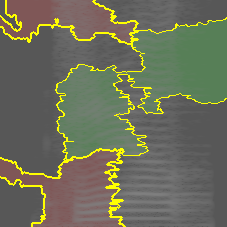

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
ImageOps.flip(array_to_img(mark_boundaries(temp / 2 + 0.5, mask)))

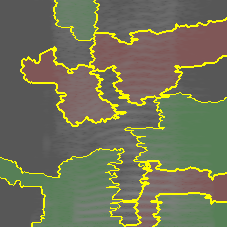

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
ImageOps.flip(array_to_img(mark_boundaries(temp / 2 + 0.5, mask)))

## try again

In [19]:
import lime
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries

# new prediction function is needed because otherwise the prediction would be made with input without resize and wrong shape 1,227,227,3 which causes an error for the grayscale trained model
def new_predict_fn(image):
    image = rgb2gray(image)
    image = image/255 # resize for the prediction
    image = image.reshape(1,227,227,1) # reshape to expected input shape 
    return model.predict(image)

In [33]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
spectrogram_data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'58/AlexNet_0_58_0.hdf5'))
# reshape image to grayscale
#img = spectrogram_data.reshape(227,227,1)

# # reshape data for model
spectrogram_data = np.squeeze(spectrogram_data)
x_cur = gray2rgb(spectrogram_data) # explain_instance function expects a rgb input

In [36]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_cur, new_predict_fn, top_labels=2,num_samples=100, batch_size=1, hide_color=0)

  0%|          | 0/100 [00:00<?, ?it/s]

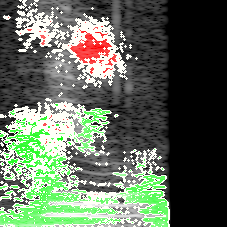

[1, 0]

In [37]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
display(ImageOps.flip(array_to_img(mark_boundaries(temp / 2 + 0.5, mask))))
explanation.top_labels

# LRP Toolbox

In [16]:
from lrp_toolbox_python import *

In [9]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
spectrogram_data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'58/AlexNet_0_58_0.hdf5'))
spectrogram_data = np.squeeze(spectrogram_data)
x_cur = spectrogram_data/255
x_cur = x_cur.reshape(1,227,227,1)

In [ ]:
# geht nicht da nicht für Keras

# new try wrapper

In [14]:
from interprettensor_master.interprettensor.modules import *

AttributeError: ignored

In [10]:
model = load_model(os.path.join(paths['models'],'AlexNet_gender_0.h5'))
spectrogram_data,_ = read_single_spectrogram_hdf5(os.path.join(paths['spectrograms'],'58/AlexNet_0_58_0.hdf5'))
spectrogram_data = np.squeeze(spectrogram_data)
x_cur = spectrogram_data/255
x_cur = x_cur.reshape(1,227,227,1)